# Upload dataset and add features

In [2]:
import pandas as pd
import numpy as np
import re
from geopy.distance import geodesic
from datetime import datetime
import requests
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('Houses.csv', encoding='ISO-8859-2', index_col='Unnamed: 0')

In [4]:
df.head()

,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,Podgórze Zabłocie Stanisława Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,Praga-Południe Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,Grunwald,Poznań,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23764 entries, 0 to 23763
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    23764 non-null  object 
 1   city       23764 non-null  object 
 2   floor      23764 non-null  float64
 3   id         23764 non-null  float64
 4   latitude   23764 non-null  float64
 5   longitude  23764 non-null  float64
 6   price      23764 non-null  float64
 7   rooms      23764 non-null  float64
 8   sq         23764 non-null  float64
 9   year       23764 non-null  float64
dtypes: float64(8), object(2)
memory usage: 2.0+ MB


In [6]:
# Check unique value of the city column
df['city'].unique()

array(['Kraków', 'Warszawa', 'Poznań'], dtype=object)

In [7]:
# Filter target city
df = df[df['city']=='Warszawa'].reset_index(drop=True)

In [8]:
# Check address column
df['address']

0                               Praga-Południe Grochowska
1       Ochota Gotowy budynek. Stan deweloperski. Osta...
2                                            Mokotów Pory
3                                          Ursynów Wyżyny
4                                                  Bemowo
                              ...                        
9846                          Mokotów Służewiec Bokserska
9847                         Bemowo ul. Antoniego Kocjana
9848                                    Rembertów Gwarków
9849                                               Włochy
9850                                              Ursynów
Name: address, Length: 9851, dtype: object

In [9]:
# Create district column based on address column
districts = [
    "Białołęka", "Bemowo", "Ochota", "Praga-Północ", "Śródmieście", "Ursus",
    "Wawer", "Wilanów", "Wola", "Bielany", "Mokotów", "Praga-Południe",
    "Rembertów", "Targówek", "Ursynów", "Wesoła", "Włochy", "Żoliborz"
]

# Function to extract district from address
def extract_district(address):
    if "ródmiecie" in address:
        return "Śródmieście"

    if "Centrum" in address:
        return "Śródmieście"

    if "Metro Wilanowska" in address:
        return "Mokotów"

    for district in districts:
        if re.search(r'\b' + re.escape(district) + r'\b', address, flags=re.IGNORECASE):
            return district
    return None

# Apply above function to the address column
df['district'] = df['address'].apply(extract_district)

In [10]:
# Check number of missing value
missing_district_rows = df[df['district'].isna()]
print(len(missing_district_rows))

50


In [11]:
# Drop missing value
df = df.dropna()

In [12]:
# Function to calculate distance to the nearest metro station
def find_nearest_metro(houses_file):

    # List of metro stations with coordinates
    metro_stations = [
        ("Kabaty", 52.1347, 21.0606),
        ("Natolin", 52.1413, 21.0576),
        ("Imielin", 52.1506, 21.0453),
        ("Stokłosy", 52.1567, 21.0329),
        ("Ursynów", 52.1642, 21.0206),
        ("Służew", 52.1698, 21.0046),
        ("Wilanowska", 52.1750, 21.0031),
        ("Wierzbno", 52.1825, 21.0033),
        ("Racławicka", 52.1894, 21.0044),
        ("Pole Mokotowskie", 52.1972, 21.0081),
        ("Politechnika", 52.2081, 21.0175),
        ("Centrum", 52.2290, 21.0109),
        ("Świętokrzyska", 52.2356, 21.0125),
        ("Ratusz Arsenał", 52.2434, 21.0040),
        ("Dworzec Gdański", 52.2550, 20.9956),
        ("Plac Wilsona", 52.2675, 20.9819),
        ("Marymont", 52.2758, 20.9714),
        ("Słodowiec", 52.2836, 20.9642),
        ("Stare Bielany", 52.2906, 20.9569),
        ("Wawrzyszew", 52.2978, 20.9475),
        ("Młociny", 52.3042, 20.9347),
        ("Księcia Janusza", 52.2361, 20.9525),
        ("Młynów", 52.2414, 20.9636),
        ("Płocka", 52.2325, 20.9778),
        ("Rondo Daszyńskiego", 52.2322, 20.9836),
        ("Rondo ONZ", 52.2325, 20.9981),
        ("Nowy Świat-Uniwersytet", 52.2350, 21.0197),
        ("Centrum Nauki Kopernik", 52.2372, 21.0311),
        ("Stadion Narodowy", 52.2444, 21.0444),
        ("Dworzec Wileński", 52.2514, 21.0342),
        ("Szwedzka", 52.2581, 21.0306),
        ("Targówek Mieszkaniowy", 52.2656, 21.0367),
        ("Trocka", 52.2728, 21.0425),
        ("Zacisze", 52.2750, 21.0483),
        ("Kondratowicza", 52.2814, 21.0597),
        ("Bródno", 52.2864, 21.0694),
    ]

    def get_nearest_metro(lat, lon):
        min_distance = float('inf')
        nearest_metro = None
        for name, m_lat, m_lon in metro_stations:
            distance = geodesic((lat, lon), (m_lat, m_lon)).km
            if distance < min_distance:
                min_distance = distance
                nearest_metro = name
        return nearest_metro, min_distance

    # Apply function to each house
    df[['nearest_metro', 'distance_to_nearest_metro']] = df.apply(
        lambda row: pd.Series(get_nearest_metro(row['latitude'], row['longitude'])), axis=1
    )

    return df

# Apply the function find_nearest_metro
df = find_nearest_metro(df)

In [13]:
# Function to calculate distance to the centrum (Palac Kultury i Nauki Warszawa)
def distance_to_pkin(houses_file):

    # PKiN coordinates
    pkin_coords = (52.2318, 21.0064)

    # Calculate distance to PKiN
    df['distance_to_pkin'] = df.apply(
        lambda row: geodesic((row['latitude'], row['longitude']), pkin_coords).km, axis=1
    )

    return df

# Apply function distance_to_pkin
df = distance_to_pkin(df)

In [14]:
df['district'].unique()

array(['Praga-Południe', 'Ochota', 'Mokotów', 'Ursynów', 'Bemowo',
       'Śródmieście', 'Białołęka', 'Wola', 'Praga-Północ', 'Wilanów',
       'Włochy', 'Żoliborz', 'Ursus', 'Bielany', 'Targówek', 'Wawer',
       'Wesoła', 'Rembertów'], dtype=object)

In [15]:
# Living condition index by district
lvi = {
    'Śródmieście': 0.842,
    'Mokotów': 0.678,
    'Ochota': 0.673,
    'Wola': 0.657,
    'Żoliborz': 0.602,
    'Praga-Południe': 0.563,
    'Włochy': 0.532,
    'Ursynów': 0.518,
    'Praga-Północ': 0.495,
    'Targówek': 0.495,
    'Wesoła': 0.459,
    'Wilanów': 0.401,
    'Wawer': 0.380,
    'Bielany': 0.359,
    'Rembertów': 0.354,
    'Bemowo': 0.326,
    'Ursus': 0.300,
    'Białołęka': 0.265
}

district_data = pd.DataFrame(list(lvi.items()), columns=["district", "living_condition_index"])

# Create range for the living_condition_index
district_data['min_index'] = district_data['living_condition_index'] * 0.9
district_data['max_index'] = district_data['living_condition_index'] * 1.1

district_data.head()

,district,living_condition_index,min_index,max_index
0,Śródmieście,0.842,0.7578,0.9262
1,Mokotów,0.678,0.6102,0.7458
2,Ochota,0.673,0.6057,0.7403
3,Wola,0.657,0.5913,0.7227
4,Żoliborz,0.602,0.5418,0.6622


In [16]:
# Create living_condition_index feature for the dataset
df = df.merge(district_data[['district', 'min_index', 'max_index']], on='district', how='left')

In [17]:
# Simulate value from the min-max range
df['living_condition_index'] = df.apply(
    lambda row: np.random.uniform(row['min_index'], row['max_index']), axis=1
)

df.head()

,address,city,floor,id,latitude,longitude,price,rooms,sq,year,district,nearest_metro,distance_to_nearest_metro,distance_to_pkin,min_index,max_index,living_condition_index
0,Praga-Południe Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0,Praga-Południe,Stadion Narodowy,4.309424,7.149523,0.5067,0.6193,0.545464
1,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0,Ochota,Płocka,2.283529,3.173344,0.6057,0.7403,0.721472
2,Mokotów Pory,Warszawa,10.0,13308.0,52.184058,21.044302,2890000.0,6.0,280.00,2003.0,Mokotów,Ursynów,2.740774,5.910427,0.6102,0.7458,0.678123
3,Ursynów Wyżyny,Warszawa,3.0,11387.0,52.140282,21.056345,615000.0,4.0,63.40,1982.0,Ursynów,Natolin,0.142155,10.740926,0.4662,0.5698,0.540176
4,Bemowo,Warszawa,1.0,10904.0,52.238974,20.913288,429000.0,1.0,40.00,1999.0,Bemowo,Księcia Janusza,2.697737,6.411034,0.2934,0.3586,0.334222


In [18]:
df['year'].unique()

array([2021., 2020., 2003., 1982., 1999., 1968., 1989., 2005., 2008.,
       1960., 2013., 1890., 1972., 2019., 2009., 2018., 1974., 2017.,
       2022., 1938., 1963., 1970., 2015., 2012., 1980., 1971., 2007.,
       2001., 1973., 2006., 1975., 2000., 1978., 1987., 2004., 2016.,
       1936., 1990., 1966., 1931., 1912., 1951., 2010., 1955., 1956.,
       1983., 2011., 2014., 1965., 1967., 2002., 1952., 1964., 1977.,
       1927., 1950., 1985., 1930., 1976., 1953., 1969., 1979., 1988.,
       1954., 1939., 1998., 1911., 1997., 1962., 1959., 1981., 2023.,
       1900., 1879., 1946., 1995., 1908., 1937.,   75., 1994., 1923.,
       1935., 1880., 1949., 1992., 1920., 1958., 1993., 1948., 1910.,
       1996., 1991., 1924., 1957., 1984., 1986., 1925., 1913., 1926.,
       1922., 1961., 1895., 1932., 1854., 1886., 1901., 1929., 1916.,
       1830., 1934., 2980.,   80., 1947., 1914., 1898., 1902., 1928.,
       1918., 1940., 1904., 1784., 1876., 1915., 1906., 1921.,   81.,
       1905., 1760.,

In [19]:
# Filter years that after 2021
df = df[df['year'] <= 2021]

# Create age_of_house feature
df['age_of_house'] = 2021 - df['year']

In [20]:
# Crawl AQI data from website

# Token
token = "e8fe79a725c31a3bc947d245795bde96c5a85f6e"

# District location
district_loc = [
    ("Bemowo", 52.2444, 20.9089),
    ("Białołęka", 52.3211, 20.9722),
    ("Bielany", 52.2925, 20.9358),
    ("Mokotów", 52.1936, 21.0219),
    ("Ochota", 52.2208, 20.9858),
    ("Praga-Południe", 52.2417, 21.0833),
    ("Praga-Północ", 52.2583, 21.0333),
    ("Rembertów", 52.2606, 21.1636),
    ("Śródmieście", 52.2297, 21.0122),
    ("Targówek", 52.2833, 21.0500),
    ("Ursus", 52.1958, 20.8842),
    ("Ursynów", 52.1500, 21.0333),
    ("Wawer", 52.2167, 21.1667),
    ("Wesoła", 52.2500, 21.2333),
    ("Wilanów", 52.1667, 21.0833),
    ("Włochy", 52.2000, 20.9167),
    ("Wola", 52.2333, 20.9667),
    ("Żoliborz", 52.2667, 20.9833),
]

# Function to get AQI
def get_air_quality(lat, lng, token):
    url = f"https://api.waqi.info/feed/geo:{lat};{lng}/?token={token}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data["status"] == "ok":
            return data["data"]
    return None

aqi_mapping = {}

for district in district_loc:
    name, lat, lng = district
    air_quality_data = get_air_quality(lat, lng, token)
    if air_quality_data:
        aqi = air_quality_data.get("aqi", "N/A")  
        aqi_mapping[name] = aqi  
    else:
        aqi_mapping[name] = "N/A"  
        print(f"{name}: Cannot get data")

# Result
print("AQI of districts:")
print(aqi_mapping)

AQI of districts:
{'Bemowo': 89, 'Białołęka': 69, 'Bielany': 105, 'Mokotów': 105, 'Ochota': 105, 'Praga-Południe': 69, 'Praga-Północ': 69, 'Rembertów': 69, 'Śródmieście': 105, 'Targówek': 69, 'Ursus': 89, 'Ursynów': 105, 'Wawer': 92, 'Wesoła': 92, 'Wilanów': 105, 'Włochy': 89, 'Wola': 105, 'Żoliborz': 105}


In [21]:
aqi_mapping_final = {'Bemowo': 113, 'Białołęka': 108, 'Bielany': 121, 'Mokotów': 121, 'Ochota': 121, 'Praga-Południe': 108, 'Praga-Północ': 108, 'Rembertów': 108, 'Śródmieście': 121, 'Targówek': 108, 'Ursus': 113, 'Ursynów': 121, 'Wawer': 177, 'Wesoła': 177, 'Wilanów': 121, 'Włochy': 113, 'Wola': 121, 'Żoliborz': 121}

In [22]:
# Add AQI feature 
df["aqi"] = df["district"].map(aqi_mapping_final)

In [23]:
# Create crime rate by district dictionary
crime_rate_dict = {
    "Śródmieście": 0.0748,
    "Praga-Północ": 0.06199,
    "Ochota": 0.0492,
    "Wola": 0.03379,
    "Bielany": 0.03344,
    "Bemowo": 0.03095,
    "Włochy": 0.03066,
    "Praga-Południe": 0.02937,
    "Targówek": 0.02886,
    "Rembertów": 0.02819,
    "Białołęka": 0.0245,
    "Mokotów": 0.02118,
    "Ursus": 0.01949,
    "Wesoła": 0.01909,
    "Ursynów": 0.01899,
    "Wawer": 0.0163,
    "Żoliborz": 0.01591,
    "Wilanów": 0.01583
}

df['crime_rate'] = df['district'].map(crime_rate_dict)

In [24]:
# Standardize and create es_index feature
scaler = MinMaxScaler()
df[["aqi_std", "crime_rate_std"]] = scaler.fit_transform(df[["aqi", "crime_rate"]])

# Calculate es_index by district
df["es_index_by_district"] = 1 - (0.5 * df["aqi_std"] + 0.5 * df["crime_rate_std"])

# Create range for es_index by distric
df['min_es_index'] = df['es_index_by_district'] * 0.9
df['max_es_index'] = df['es_index_by_district'] * 1.1

# Create es_index feature
df['es_index'] = df.apply(
    lambda row: np.random.uniform(row['min_es_index'], row['max_es_index']), axis=1
)

In [25]:
df.head()

,address,city,floor,id,latitude,longitude,price,rooms,sq,year,...,living_condition_index,age_of_house,aqi,crime_rate,aqi_std,crime_rate_std,es_index_by_district,min_es_index,max_es_index,es_index
0,Praga-Południe Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0,...,0.545464,0.0,108,0.02937,0.000000,0.229608,0.885196,0.796676,0.973715,0.961062
1,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0,...,0.721472,1.0,121,0.04920,0.188406,0.565881,0.622857,0.560571,0.685142,0.596662
2,Mokotów Pory,Warszawa,10.0,13308.0,52.184058,21.044302,2890000.0,6.0,280.00,2003.0,...,0.678123,18.0,121,0.02118,0.188406,0.090724,0.860435,0.774392,0.946479,0.861648
3,Ursynów Wyżyny,Warszawa,3.0,11387.0,52.140282,21.056345,615000.0,4.0,63.40,1982.0,...,0.540176,39.0,121,0.01899,0.188406,0.053587,0.879004,0.791103,0.966904,0.919153
4,Bemowo,Warszawa,1.0,10904.0,52.238974,20.913288,429000.0,1.0,40.00,1999.0,...,0.334222,22.0,113,0.03095,0.072464,0.256402,0.835567,0.752011,0.919124,0.886044


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8926 entries, 0 to 9800
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   address                    8926 non-null   object 
 1   city                       8926 non-null   object 
 2   floor                      8926 non-null   float64
 3   id                         8926 non-null   float64
 4   latitude                   8926 non-null   float64
 5   longitude                  8926 non-null   float64
 6   price                      8926 non-null   float64
 7   rooms                      8926 non-null   float64
 8   sq                         8926 non-null   float64
 9   year                       8926 non-null   float64
 10  district                   8926 non-null   object 
 11  nearest_metro              8926 non-null   object 
 12  distance_to_nearest_metro  8926 non-null   float64
 13  distance_to_pkin           8926 non-null   float64
 1

In [27]:
# Drop unecessary column
drop_col = [
    "year", "latitude", "longitude", "min_index", "max_index", 
    "id", "city", "address", "nearest_metro", "aqi", "crime_rate", 
    "aqi_std", "crime_rate_std", "es_index_by_district", "min_es_index", "max_es_index"]
    
df=df.drop(drop_col, axis=1)

In [28]:
# Correct features data type
df = df.astype({
    "floor": "category",
    "rooms": "category",
    "district": "category",
    "age_of_house": "int64"
})

In [29]:
# Move price column to the last column
df["price"] = df.pop("price")

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8926 entries, 0 to 9800
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   floor                      8926 non-null   category
 1   rooms                      8926 non-null   category
 2   sq                         8926 non-null   float64 
 3   district                   8926 non-null   category
 4   distance_to_nearest_metro  8926 non-null   float64 
 5   distance_to_pkin           8926 non-null   float64 
 6   living_condition_index     8926 non-null   float64 
 7   age_of_house               8926 non-null   int64   
 8   es_index                   8926 non-null   float64 
 9   price                      8926 non-null   float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 585.5 KB


In [31]:
df.head()

,floor,rooms,sq,district,distance_to_nearest_metro,distance_to_pkin,living_condition_index,age_of_house,es_index,price
0,3.0,1.0,24.38,Praga-Południe,4.309424,7.149523,0.545464,0,0.961062,240548.0
1,1.0,5.0,105.00,Ochota,2.283529,3.173344,0.721472,1,0.596662,996000.0
2,10.0,6.0,280.00,Mokotów,2.740774,5.910427,0.678123,18,0.861648,2890000.0
3,3.0,4.0,63.40,Ursynów,0.142155,10.740926,0.540176,39,0.919153,615000.0
4,1.0,1.0,40.00,Bemowo,2.697737,6.411034,0.334222,22,0.886044,429000.0


In [32]:
df.to_csv("final_dataset.csv", index=False)

# Exploratory Data Analysis

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8926 entries, 0 to 9800
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   floor                      8926 non-null   category
 1   rooms                      8926 non-null   category
 2   sq                         8926 non-null   float64 
 3   district                   8926 non-null   category
 4   distance_to_nearest_metro  8926 non-null   float64 
 5   distance_to_pkin           8926 non-null   float64 
 6   living_condition_index     8926 non-null   float64 
 7   age_of_house               8926 non-null   int64   
 8   es_index                   8926 non-null   float64 
 9   price                      8926 non-null   float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 585.5 KB


In [36]:
df.describe()

,sq,distance_to_nearest_metro,distance_to_pkin,living_condition_index,age_of_house,es_index,price
count,8926.000000,8926.000000,8926.000000,8926.000000,8926.000000,8926.000000,8.926000e+03
mean,62.535965,2.849715,6.335962,0.557437,27.593883,0.779816,7.967195e+05
std,32.680181,16.975412,17.303259,0.173540,50.328818,0.167262,7.227986e+05
min,8.800000,0.031617,0.028324,0.238573,0.000000,0.365227,5.000000e+03
25%,43.000000,0.588504,3.560947,0.396689,2.000000,0.715081,4.700000e+05
50%,54.500000,1.472346,5.203463,0.586926,16.000000,0.825091,5.990000e+05
75%,72.000000,2.896159,7.857964,0.679117,48.000000,0.899117,8.490000e+05
max,368.000000,1143.156550,1148.749950,0.925634,1946.000000,1.023772,1.500000e+07


In [37]:
df.describe(include=["category"])

,floor,rooms,district
count,8926.0,8926.0,8926
unique,11.0,9.0,18
top,1.0,2.0,Mokotów
freq,1675.0,3362.0,1402


In [38]:
# Check missing data
df.isnull().sum()

floor                        0
rooms                        0
sq                           0
district                     0
distance_to_nearest_metro    0
distance_to_pkin             0
living_condition_index       0
age_of_house                 0
es_index                     0
price                        0
dtype: int64

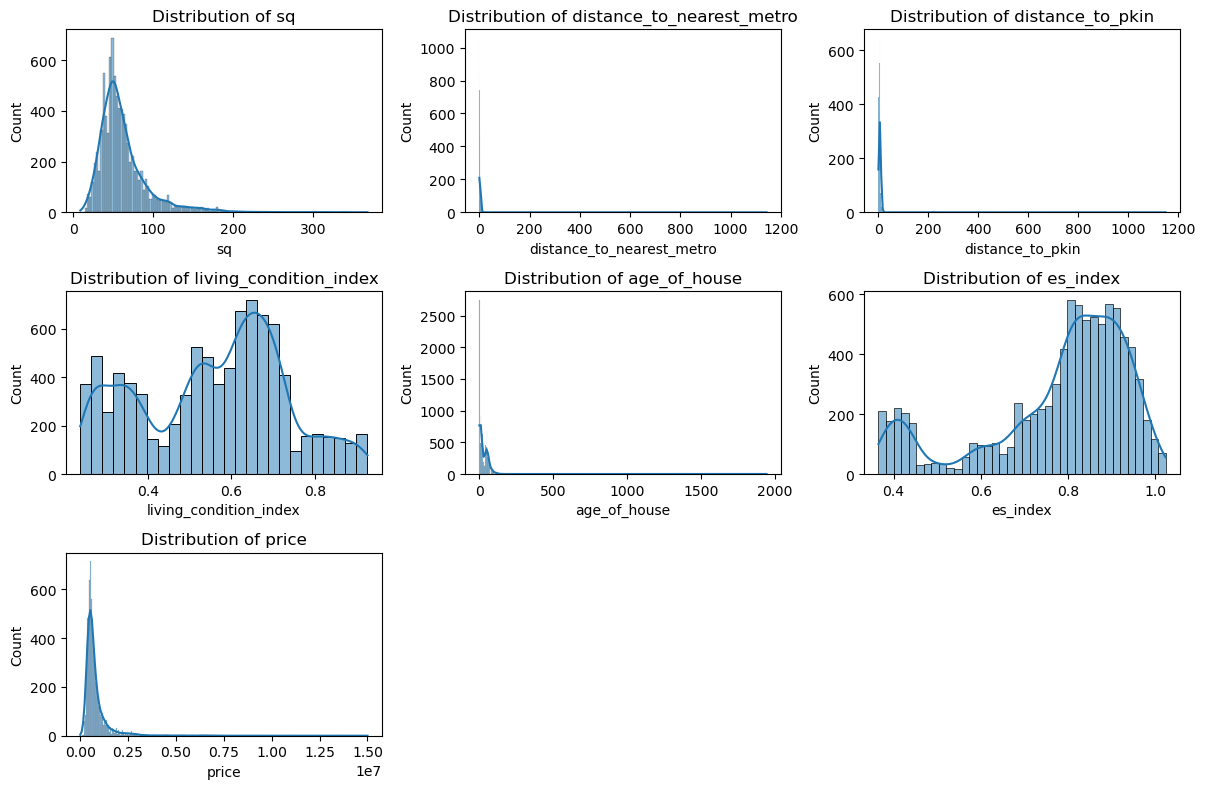

In [39]:
# Numeric feature distribution
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))

for i, col in enumerate(numeric_columns):
    row = i // 3
    col_idx = i % 3
    sns.histplot(df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribution of {col}')
fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])
plt.tight_layout()
plt.show()

***Observation:***
- Features except `living_condition_index` and `es_index` are all right-skewed
- We need to deal with long tail variables (outliers) like `sq`, `distance_nearest_metro`, `age_of_house` or `distance_to_pkin`
- Moreover, target variable - `price` is also right-skwed, but outliers are valid values ​​(e.g. cheap houses in a particular area), removing them may lose important information.

**-> we can standard scaler or use transformation method it later in model training**

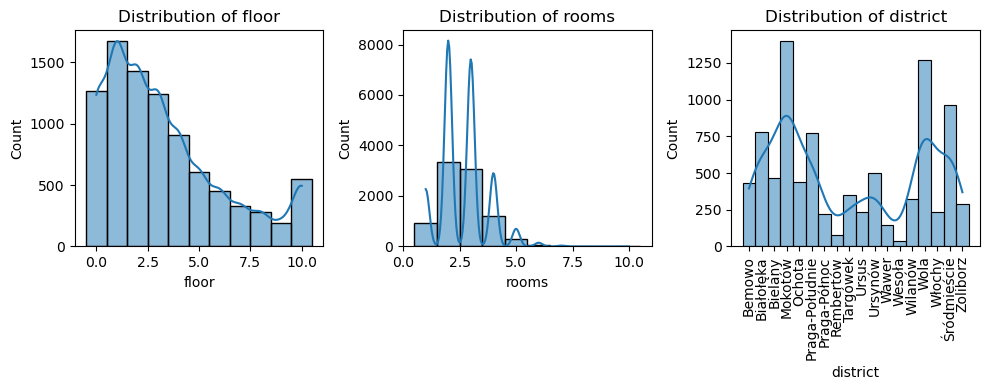

In [41]:
# Categorical feature distribution
category_columns = df.select_dtypes(include=['category']).columns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

for i, col in enumerate(category_columns):
    row = i // 3
    col_idx = i % 3
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- `floor` and `rooms` are also right-skwed, with many values ​​concentrated on the left side and some extremely large values ​​on the right side.

  -> Right-skewed variables can degrade model performance, especially models that rely on normal distribution assumptions such as linear regression. To improve model performance, we need to apply data transformation methods to reduce skew.

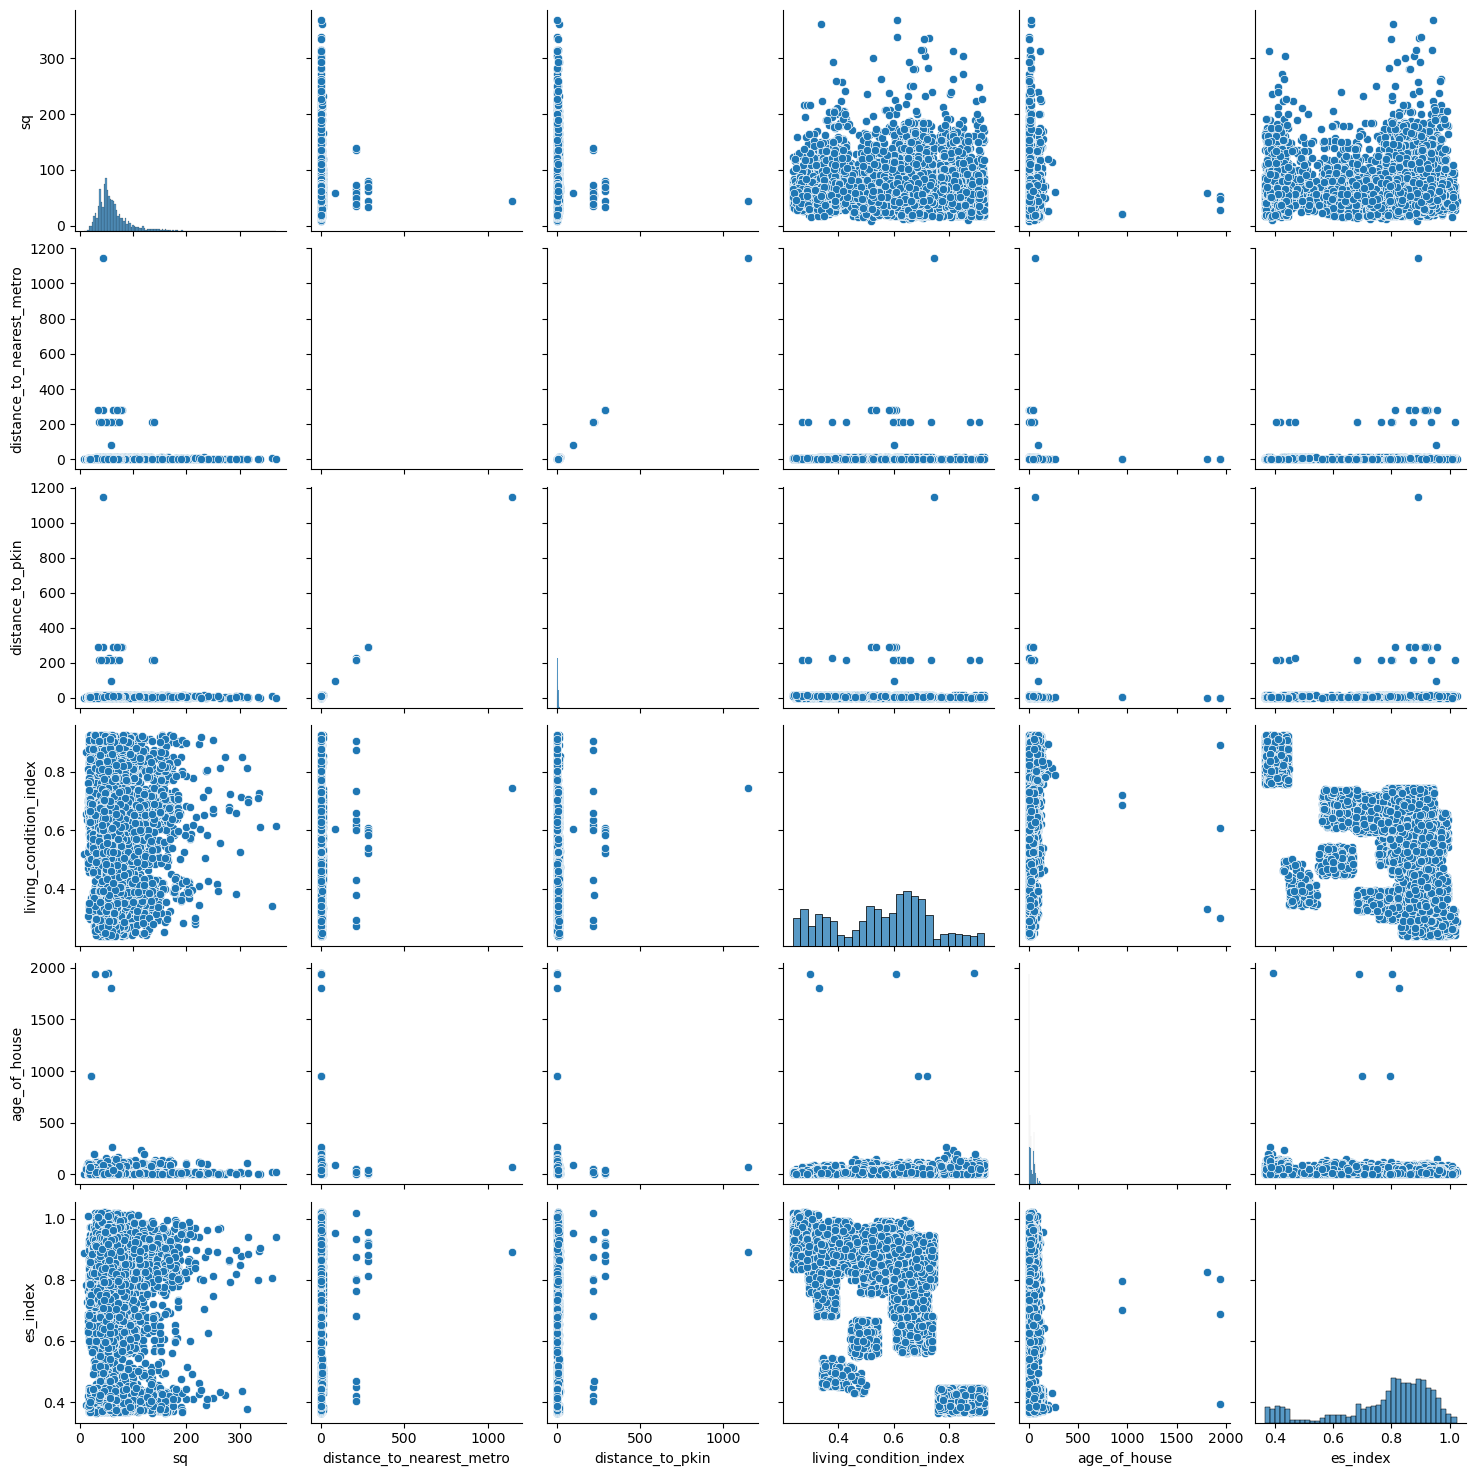

In [43]:
# Pairplot to check relationship between features
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numcols_except_price = numeric_columns.drop('price')
sns.pairplot(df[numcols_except_price])

plt.show()

***Observation***
- `age_of_house` has some very large data points (over 1000 years), possibly a data error or some historical buildings.
- `living_condition_index` and `es_index` have clustered data, possibly due to some predefined classification or rating.
It is worth noting that `es_index` and `living_condition_index` may have a close relationship, as both are related to living conditions.

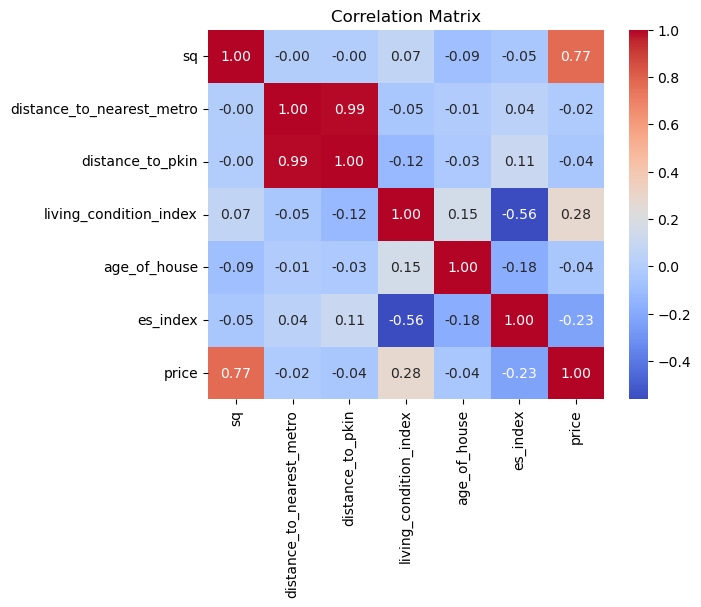

In [45]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

- The most valuable variables for model prediction: `sq` with strong correlation (0.77), followed by `living_condition_index` when it has a positive correlation with price.

- `distance_to_nearest_metro` and `distance_to_pkin` have very strong correlation with each other (0.99). So one of the two variables can be removed to avoid multicollinearity.

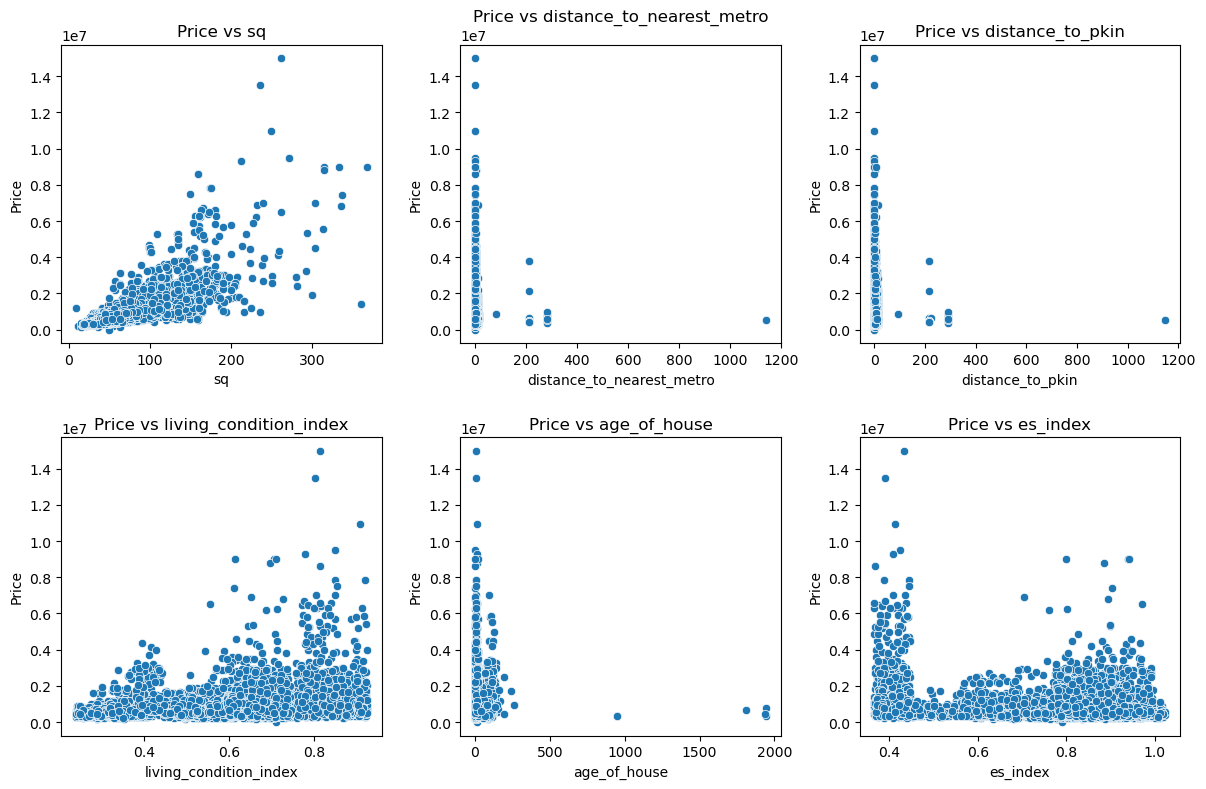

In [47]:
n_cols = 3
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

axes = axes.flatten()

# Scatter plot to check the relationship between numeric features and the target variable
for i, col in enumerate(numcols_except_price):
    sns.scatterplot(data=df, x=col, y='price', ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

for i in range(len(numcols_except_price), n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

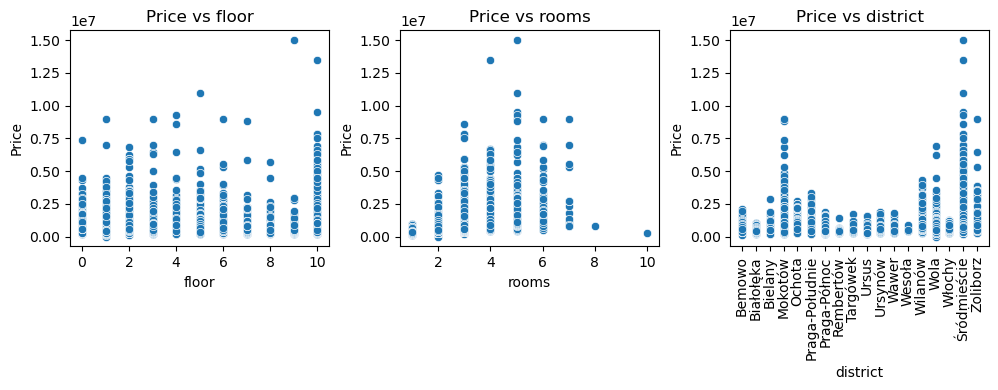

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

axes = axes.flatten()

# Scatter plot to check relationship between categorical features and the target variable
for i, col in enumerate(category_columns):
    sns.scatterplot(data=df, x=col, y='price', ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

for i in range(len(numcols_except_price), n_rows * n_cols):
    fig.delaxes(axes[i])

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- `Price` vs `floor`: House prices do not appear to have a clear linear relationship with floor. However, there may be some higher prices on certain floors (possibly due to penthouses or nicer floors).
→ This feature should not be used linearly, try One-Hot Encoding or treat it as a categorical variable.

- `Price` vs `rooms`: Data points are concentrated at room numbers 1, 2, 3 but there is no clear linear trend. → Feature engineering should be tested, such as combining with square footage (sq/rooms) for more useful information.

- `Price` vs `sq` (area): House prices increase with area, with a linear trend but some outliers.

- `Price` vs `distance_to_nearest_metro` & `distance_to_pkin`: Both have an inverse relationship with house prices, with house prices being higher the closer to the metro or the center (pkin). However, the relationship does not seem to be linear, but declines sharply at around 0-3 km and then slows down.

- `Price` vs `living_condition_index`: There is an increasing trend as the living conditions index increases, but there is quite a large dispersion.

- `Price` vs `age_of_house`: There is an inverse trend, but there is quite a large dispersion. The older the house, the lower the price, but not always.

→ We can try log(age_of_house) or group by age range (new < 10 years, middle-aged 10-50 years, old > 50 years).

- `Prices` do not have a clear increase according to `es_index`. Instead, there is a cluster concentrated at es_index levels from 0.7 and above but still has prices ranging from low to high.
At low es_index levels (≈0.4 - 0.6), there are some very high house price points, possibly due to other special properties such as location, large area. At high es_index levels (≈0.9 - 1.0), house prices do not seem to increase as strongly as expected, on the contrary, there are many data points at low average prices.
→ The es_index does not have a clear linear relationship with house prices. It is possible that other factors such as location, area, or distance to the center play a more important role.

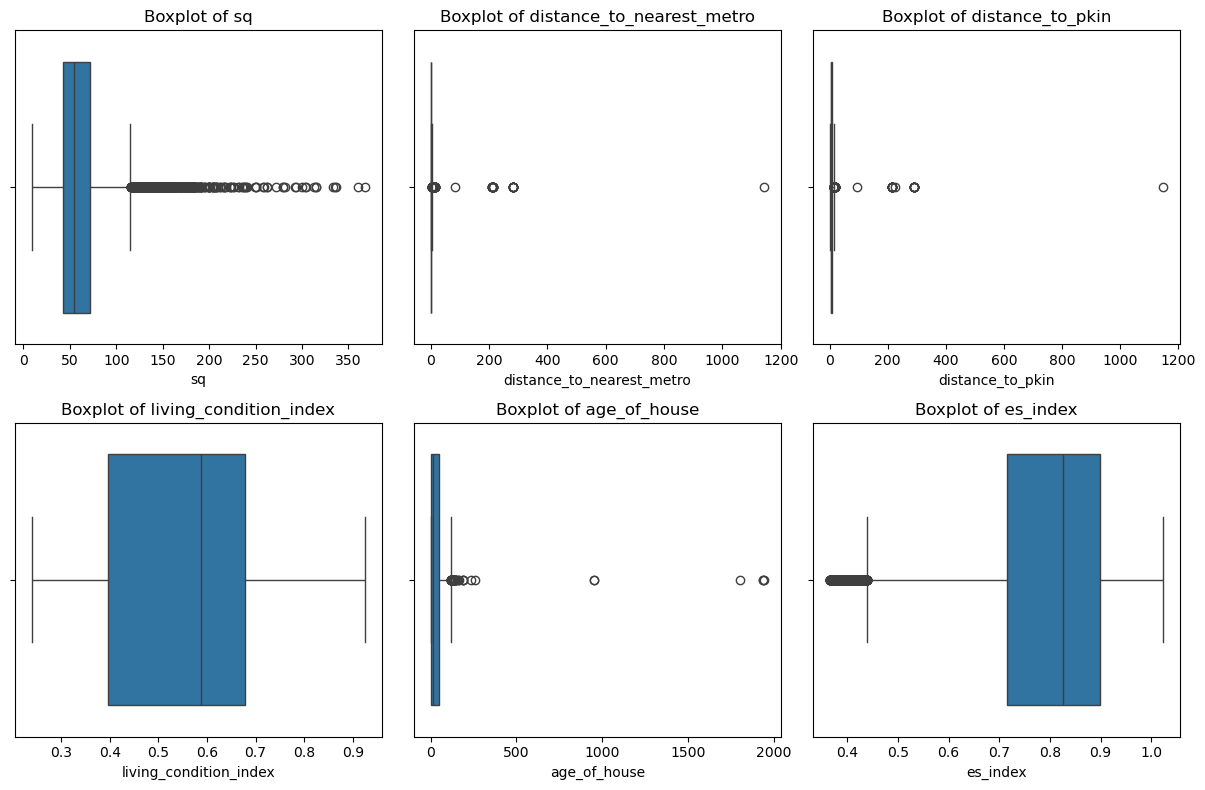

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

axes = axes.flatten()

for i, col in enumerate(numcols_except_price):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

for i in range(len(numcols_except_price), n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

- Although variables sq, distance_to_nearest_metro, distance_to_pkin have outliers, they provide important and meaningful data information for the model.

# Model training and evaluation

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

In [56]:
# Data preprocessing
X = df.drop('price', axis=1)
y = df['price']

# Split dataset into train, test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing 
numeric_features = ['sq', 'distance_to_nearest_metro', 'distance_to_pkin', 'living_condition_index', 'age_of_house', 'es_index']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['floor', 'rooms', 'district']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [57]:
# Define testing models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Neural Network': MLPRegressor(random_state=42, max_iter=1000),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

# Train and evaluate models
results = []
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

# Result
results_df = pd.DataFrame(results)
results_df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,MAE,RMSE,R2
0,Linear Regression,190648.713386,348733.271105,0.711199
1,Random Forest,91834.251606,205656.709896,0.899562
2,Gradient Boosting,115402.073158,232755.965817,0.871349
3,SVR,327228.782154,675188.866257,-0.082585
4,Decision Tree,118887.040946,283813.366010,0.808717
5,Neural Network,385126.836181,654450.453693,-0.017103
6,XGBoost,94464.856750,210719.841985,0.894556


n_estimators = 10, MAE = 99881.53347424412
n_estimators = 50, MAE = 92352.38396786115
n_estimators = 100, MAE = 91834.251606271
n_estimators = 200, MAE = 91501.50380562712
n_estimators = 300, MAE = 91780.2349490046
n_estimators = 400, MAE = 91616.24020037794
n_estimators = 500, MAE = 91666.98653976484


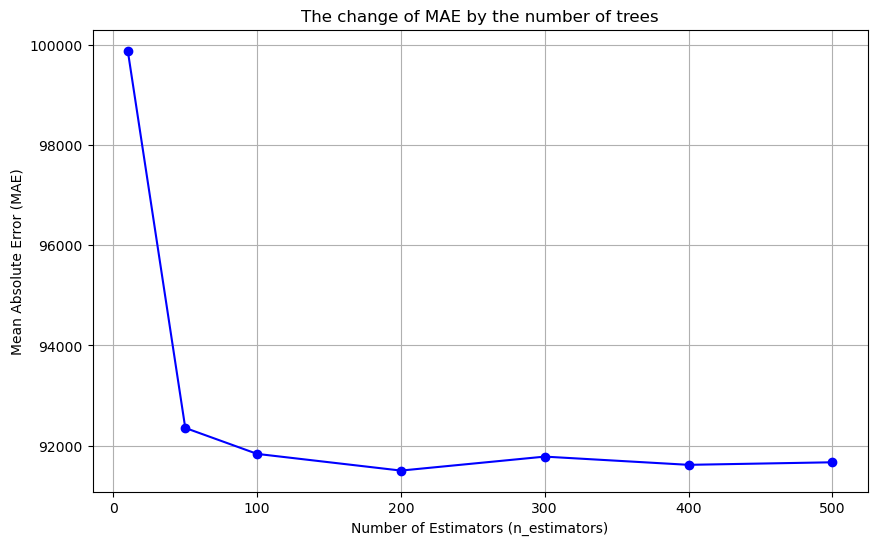

In [58]:
# Finding the optimal number of tree parameter
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# List of number of estimators
n_estimators_list = [10, 50, 100, 200, 300, 400, 500]

# MAE list
mae_scores = []

# Train model an get MAE
for n_estimators in n_estimators_list:
    pipeline.set_params(regressor__n_estimators=n_estimators)
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
    print(f"n_estimators = {n_estimators}, MAE = {mae}")

# Visualize the change of MAE
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, mae_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('The change of MAE by the number of trees')
plt.grid(True)
plt.show()

In [59]:
# Model Random Forest Regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42,
                                       n_estimators=200))
])

# Train model
pipeline.fit(X_train, y_train)

# Prediction
y_pred = pipeline.predict(X_test)

# Evaluate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Result
print("Random Forest Regressor Performance:")
print(f"  MAE: {mae}")
print(f"  RMSE: {rmse}")
print(f"  R²: {r2}")

Random Forest Regressor Performance:
  MAE: 91501.50380562712
  RMSE: 205764.7456107188
  R²: 0.8994566372446304


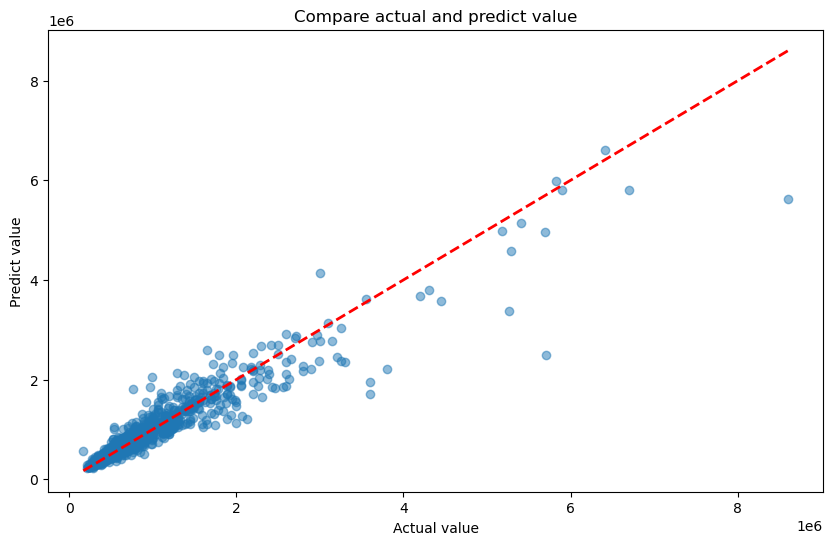

In [60]:
# y_test vs y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual value')
plt.ylabel('Predict value')
plt.title('Compare actual and predict value')
plt.show()

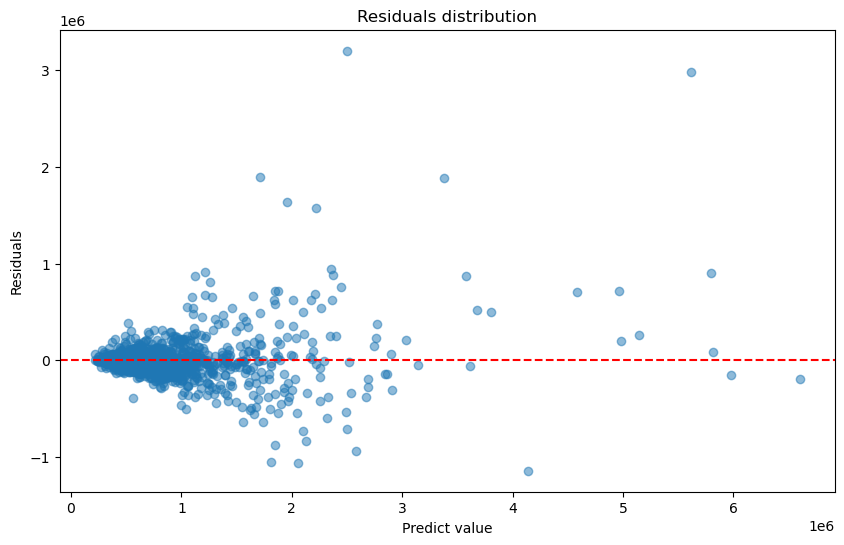

In [61]:
# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predict value')
plt.ylabel('Residuals')
plt.title('Residuals distribution')
plt.show()

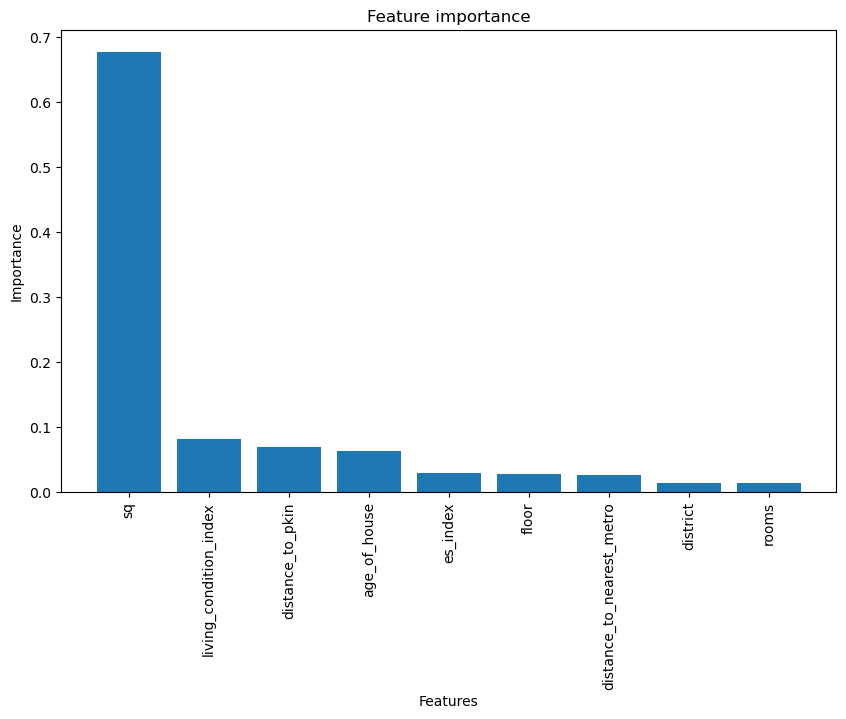

In [62]:
# Feature importance
rf_model = pipeline.named_steps['regressor']
encoded_feature_names = numeric_features + list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
importances = rf_model.feature_importances_

importances = rf_model.feature_importances_

feature_importance_dict = {}

for i, feature in enumerate(encoded_feature_names):
    if any(cat_feature in feature for cat_feature in categorical_features):
        original_feature = feature.split('_')[0]

        if original_feature in feature_importance_dict:
            feature_importance_dict[original_feature] += importances[i]
        else:
            feature_importance_dict[original_feature] = importances[i]
    else:
        feature_importance_dict[feature] = importances[i]

original_features = list(feature_importance_dict.keys())
original_importances = list(feature_importance_dict.values())

indices = np.argsort(original_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature importance')
plt.bar(range(len(original_importances)), np.array(original_importances)[indices], align='center')
plt.xticks(range(len(original_importances)), np.array(original_features)[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [63]:
mean_price = y.mean()

mae_percentage = (mae / mean_price) * 100
rmse_percentage = (rmse / mean_price) * 100

print(mae_percentage)
print(rmse_percentage)

11.484782310639794
25.826496967342212


# Testing on model's complexility

In [131]:
import time
import psutil

In [133]:
# Function to evaluate time and memory usage
def measure_time_and_memory(func, *args, **kwargs):
    start_time = time.time()
    process = psutil.Process()
    start_memory = process.memory_info().rss  
    result = func(*args, **kwargs)
    end_memory = process.memory_info().rss  
    end_time = time.time()
    return result, end_time - start_time, end_memory - start_memory

In [135]:
# Data preprocessing
X = df.drop('price', axis=1)
y = df['price']

numeric_features = ['sq', 'distance_to_nearest_metro', 'distance_to_pkin', 'living_condition_index', 'age_of_house', 'es_index']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['floor', 'rooms', 'district']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [137]:
# Create pipeline with the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42,
                                       n_estimators=200))
])

In [147]:
dataset_sizes = [1000, 2000, 4000, 6000, 8000, 10000]  
training_times = []
prediction_times = []
memory_usages = []
mae_scores = []

# Check on different dataset size
for size in dataset_sizes:
    
    X_train, X_test, y_train, y_test = train_test_split(X[:size], y[:size], test_size=0.2, random_state=42)
    
    # Evaluate time and memory used to train the model
    def train_model():
        pipeline.fit(X_train, y_train)
    _, train_time, train_memory = measure_time_and_memory(train_model)
    
    # Evaluate time and memory used to make prediction
    def predict():
        return pipeline.predict(X_test)
    y_pred, predict_time, predict_memory = measure_time_and_memory(predict)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    # Save result
    training_times.append(train_time)
    prediction_times.append(predict_time)
    memory_usages.append(train_memory + predict_memory)
    mae_scores.append(mae)
    
    print(f"Dataset size = {size}, Training time = {train_time:.2f}s, Prediction time = {predict_time:.2f}s, Memory usage = {train_memory + predict_memory} bytes, MAE = {mae}")

Dataset size = 1000, Training time = 0.93s, Prediction time = 0.01s, Memory usage = 29999104 bytes, MAE = 167471.50930550002
Dataset size = 2000, Training time = 2.14s, Prediction time = 0.01s, Memory usage = 16941056 bytes, MAE = 122484.875394875
Dataset size = 4000, Training time = 5.48s, Prediction time = 0.03s, Memory usage = 9256960 bytes, MAE = 111548.99350499999
Dataset size = 6000, Training time = 9.59s, Prediction time = 0.04s, Memory usage = 65372160 bytes, MAE = 107026.64543961111
Dataset size = 8000, Training time = 14.31s, Prediction time = 0.07s, Memory usage = -13893632 bytes, MAE = 104304.38034605469
Dataset size = 10000, Training time = 16.50s, Prediction time = 0.05s, Memory usage = 8847360 bytes, MAE = 91727.38679487682


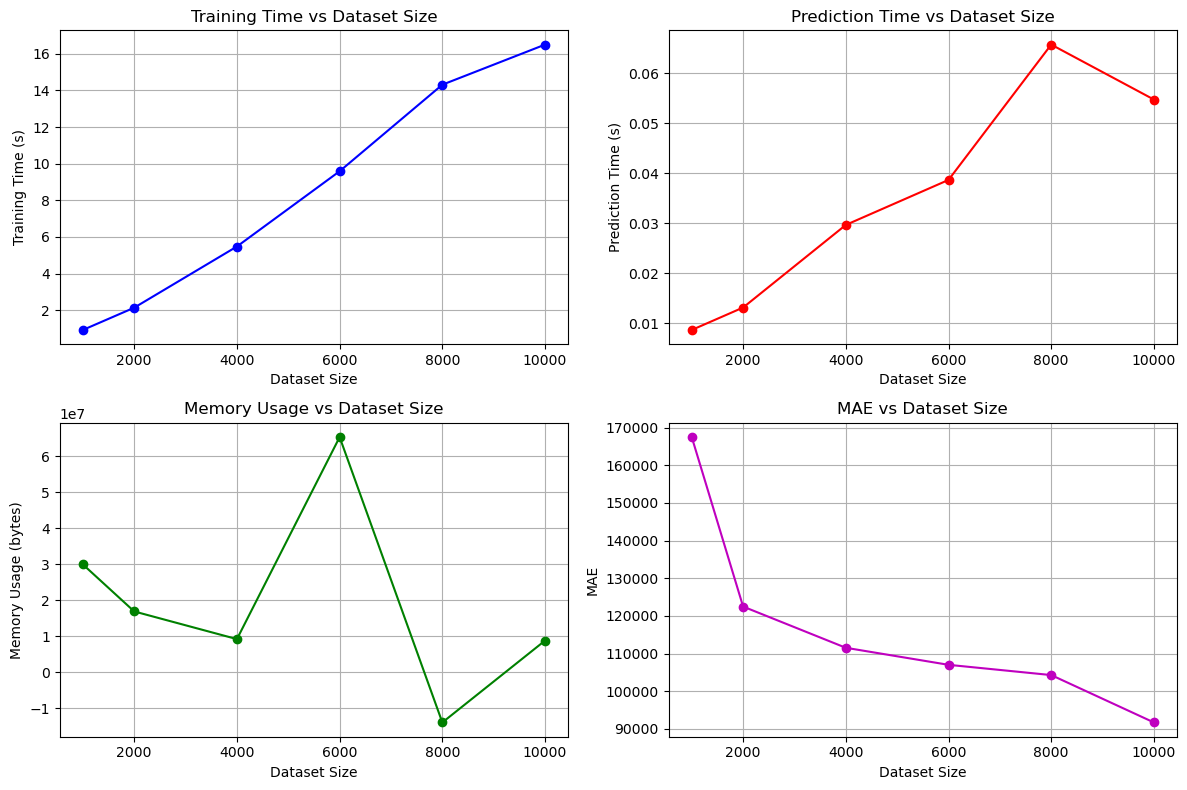

In [149]:
# Visualize result
plt.figure(figsize=(12, 8))

# Training time plot
plt.subplot(2, 2, 1)
plt.plot(dataset_sizes, training_times, marker='o', linestyle='-', color='b')
plt.xlabel('Dataset Size')
plt.ylabel('Training Time (s)')
plt.title('Training Time vs Dataset Size')
plt.grid(True)

# Predicting time plot
plt.subplot(2, 2, 2)
plt.plot(dataset_sizes, prediction_times, marker='o', linestyle='-', color='r')
plt.xlabel('Dataset Size')
plt.ylabel('Prediction Time (s)')
plt.title('Prediction Time vs Dataset Size')
plt.grid(True)

# Memory usage plot
plt.subplot(2, 2, 3)
plt.plot(dataset_sizes, memory_usages, marker='o', linestyle='-', color='g')
plt.xlabel('Dataset Size')
plt.ylabel('Memory Usage (bytes)')
plt.title('Memory Usage vs Dataset Size')
plt.grid(True)

# MAE loss plot
plt.subplot(2, 2, 4)
plt.plot(dataset_sizes, mae_scores, marker='o', linestyle='-', color='m')
plt.xlabel('Dataset Size')
plt.ylabel('MAE')
plt.title('MAE vs Dataset Size')
plt.grid(True)

plt.tight_layout()
plt.show()